# Time Series Forecasting on NYC_Taxi

w MLFlow

- Objectives
  - Leverage ML FLow to build some time series models

- Simple Forecast of aggregate daily data to start
- Later will need to look at splitting out the datasets into different spots

In [1]:
%load_ext autotime

time: 191 µs (started: 2021-08-02 12:57:55 +00:00)


In [2]:
import os
from pyspark.sql import SparkSession
packages="""io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0"""
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages io.delta:delta-core_2.12:1.0.0,org.apache.hadoop:hadoop-aws:3.2.0 pyspark-shell"

time: 99.1 ms (started: 2021-08-02 12:57:55 +00:00)


In [3]:
from pyspark.sql import functions as F
import pandas as pd

time: 104 ms (started: 2021-08-02 12:57:55 +00:00)


In [4]:
spark = SparkSession \
            .builder \
            .config("spark.executor.cores", 4) \
            .config("spark.executor.memory", "4g") \
            .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
            .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
            .config("spark.master", "spark://spark-master:7077") \
            .config("spark.hadoop.fs.s3a.access.key", os.environ['MINIO_ACCESS_KEY']) \
            .config("spark.hadoop.fs.s3a.secret.key", os.environ['MINIO_SECRET_KEY']) \
            .config("spark.hadoop.fs.s3a.endpoint", "minio:9000") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.metastore.catalog.default", "hive") \
            .config("spark.sql.warehouse.dir", "s3a://storage/warehouse") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.maximum", "50") \
            .config("spark.hive.metastore.uris", "thrift://192.168.64.4:9083") \
            .appName("Jupyter Time Series") \
            .enableHiveSupport() \
            .getOrCreate()

time: 3.29 s (started: 2021-08-02 12:57:55 +00:00)


In [5]:
# tuning settings spark.sql.shuffle.partitions to match with core settings
# not tuned for file size yet

# set to cores to increase the efficiency
spark.conf.set("spark.sql.shuffle.partitions", spark.sparkContext.defaultParallelism*4)

## faster pandas data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

time: 2.72 ms (started: 2021-08-02 12:57:59 +00:00)


In [6]:
from tseries.taxi_daily import TaxiDaily

time: 3.74 ms (started: 2021-08-02 12:57:59 +00:00)


In [7]:
taxi_daily = TaxiDaily(spark)
taxi_daily.load_data()

time: 10.9 s (started: 2021-08-02 12:57:59 +00:00)


# Settings for MLflow

In [8]:
# credentials for storing our model artifacts
# mlflow needs these to be set whenever it is being called
os.environ['AWS_ACCESS_KEY_ID'] = os.environ.get('MINIO_ACCESS_KEY')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.environ.get('MINIO_SECRET_KEY')
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://minio:9000'

time: 364 µs (started: 2021-08-02 12:58:10 +00:00)


# Create Our Train Set

In [9]:
taxi_daily.dataset.agg(F.min(F.col('pickup_date')), F.max(F.col('pickup_date'))).collect()

[Row(min(pickup_date)=datetime.date(2013, 8, 1), max(pickup_date)=datetime.date(2016, 6, 30))]

time: 12.3 s (started: 2021-08-02 12:58:10 +00:00)


In [10]:
taxi_daily.dataset.printSchema()

root
 |-- pickup_date: date (nullable = true)
 |-- total_rides: long (nullable = false)
 |-- total_takings: double (nullable = true)

time: 7.49 ms (started: 2021-08-02 12:58:22 +00:00)


Lets take 2 years to start

In [11]:
starting_dataset = taxi_daily.dataset.filter("pickup_date < '2015-09-01'")

time: 15.9 ms (started: 2021-08-02 12:58:22 +00:00)


In [12]:
train, val = starting_dataset.filter("pickup_date < '2015-08-01'").toPandas(), \
                starting_dataset.filter("pickup_date >= '2015-08-01'").toPandas()

time: 30.9 s (started: 2021-08-02 12:58:22 +00:00)


## Forecasting the Dataframe

In [13]:
import prophet
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import mlflow

time: 1.72 s (started: 2021-08-02 12:58:53 +00:00)


There was an error in the hostname resolution hence switch to ip

In [14]:
#mlflow.delete_experiment('1')

time: 147 µs (started: 2021-08-02 12:58:55 +00:00)


In [15]:
mlflow.set_tracking_uri("http://192.168.64.21:5000/")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: http://192.168.64.21:5000/
time: 6.27 ms (started: 2021-08-02 12:58:55 +00:00)


In [16]:
### Quick test on creating experiments
from mlflow.exceptions import RestException

try:
    mlflow.create_experiment(
        name='taxi_daily_forecast'
    )
except RestException:
    print('already_created')

already_created
time: 348 ms (started: 2021-08-02 12:58:55 +00:00)


In [17]:
experiment = mlflow.get_experiment(15)
experiment.artifact_location

's3://mlflow/15'

time: 18.3 ms (started: 2021-08-02 12:58:55 +00:00)


In [18]:
# Build an evaluation function
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

time: 192 ms (started: 2021-08-02 12:58:55 +00:00)


In [19]:
# To save models to mlflow we need to write a python wrapper 
# to make sure that it performs as mlflow expects
import mlflow.pyfunc

class ProphetModel(mlflow.pyfunc.PythonModel):
    
    def __init__(self, model):
        
        self.model = model
        super().__init__()
        
    def load_context(self, context):
        from prophet import Prophet
        return
    
    def predict(self, context, model_input):
        future = self.model.make_future_dataframe(periods=model_input['periods'][0])
        return self.model.predict(future)

time: 446 µs (started: 2021-08-02 12:58:55 +00:00)


44 seconds for training by default \
3.62 seconds with processes parallelisation \
13 seconds after we add the toPandas conversion here and run with parallelisation

In [20]:
train_prophet = train[['pickup_date', 'total_rides']]
train_prophet.columns = ['ds', 'y']
#train_prophet.head(10)

val_prophet = val[['pickup_date', 'total_rides']]
val_prophet.columns = ['ds', 'y']
#val_prophet.head(10)

time: 7.93 ms (started: 2021-08-02 12:58:55 +00:00)


In [21]:
%time

rolling_window = 0.1

conda_env = {
    'channels': ['conda-forge'],
    'dependencies': [{
        'pip': [
            'prophet=={0}'.format(prophet.__version__)
        ]
    }],
    "name": "prophetenv"
}

with mlflow.start_run(experiment_id=15):
    m = prophet.Prophet(daily_seasonality=True)
    # need to adjust the fit function to suit
    m.fit(train_prophet)
    
    # cross validation is the thingy that is generating our different train sets
    # tqdm is glitchy with my setup so disabling for now
    df_cv = cross_validation(m, initial="28 days", period="7 days", horizon="14 days", 
                                 disable_tqdm=True, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=rolling_window)
    
    mlflow.log_param("rolling_window", rolling_window)
    mlflow.log_metric("rmse", df_p.loc[0, "rmse"])
    mlflow.log_metric("mae", df_p.loc[0, "mae"])
    mlflow.log_metric("mape", df_p.loc[0, "mape"])
    
    print("  CV: {}".format(df_cv.head()))
    print("  Perf: {}".format(df_p.head()))
    
    mlflow.pyfunc.log_model("model", conda_env=conda_env, python_model=ProphetModel(m))
    print(
            "Logged model with URI: runs:/{run_id}/model".format(
                run_id=mlflow.active_run().info.run_id
            )
        )

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 5.96 µs


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Making 99 forecasts with cutoffs between 2013-08-30 00:00:00 and 2015-07-17 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9a30b70730>
INFO:prophet:n_changepoints greater than number of observations. Using 23.
INFO:botocore.credentials:Found credentials in environment variables.


  CV:           ds           yhat     yhat_lower     yhat_upper       y     cutoff
0 2013-08-31  466181.223617  396371.752570  533484.550606  435400 2013-08-30
1 2013-09-01  374580.382329  301312.167784  447489.144612  385228 2013-08-30
2 2013-09-02  476032.257442  401156.858042  547892.409148  332835 2013-08-30
3 2013-09-03  514837.634061  440256.409261  584527.933807  423109 2013-08-30
4 2013-09-04  531990.627849  465506.029664  601918.734547  454753 2013-08-30
  Perf:   horizon           mse          rmse           mae      mape     mdape  \
0  2 days  2.215221e+09  47066.132709  35935.512074  0.077096  0.057767   
1  3 days  1.659995e+09  40743.038589  29360.119607  0.070388  0.048685   
2  4 days  2.222371e+09  47142.029241  30338.046550  0.080013  0.040735   
3  5 days  1.884198e+09  43407.354720  27703.800907  0.066228  0.045150   
4  6 days  2.615026e+09  51137.326630  31998.757504  0.074340  0.039273   

      smape  coverage  
0  0.075672  0.863197  
1  0.067299  0.910628  
2

# Prophet Diagnostics

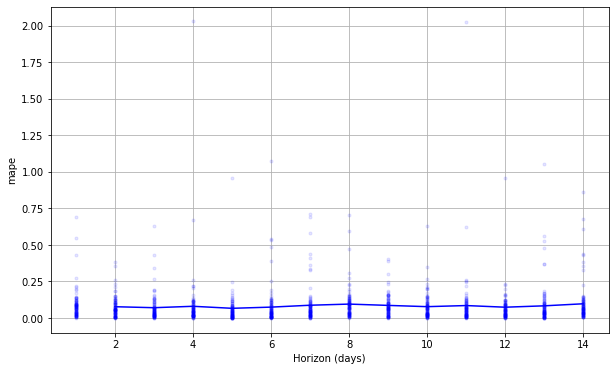

time: 119 ms (started: 2021-08-02 12:59:03 +00:00)


In [22]:
# Python
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

We aren't seeing many differences with longer horizons

In [23]:
future = m.make_future_dataframe(periods=len(val_prophet))

time: 1.18 ms (started: 2021-08-02 12:59:03 +00:00)


In [24]:
forecast = m.predict(future)

time: 1.9 s (started: 2021-08-02 12:59:03 +00:00)


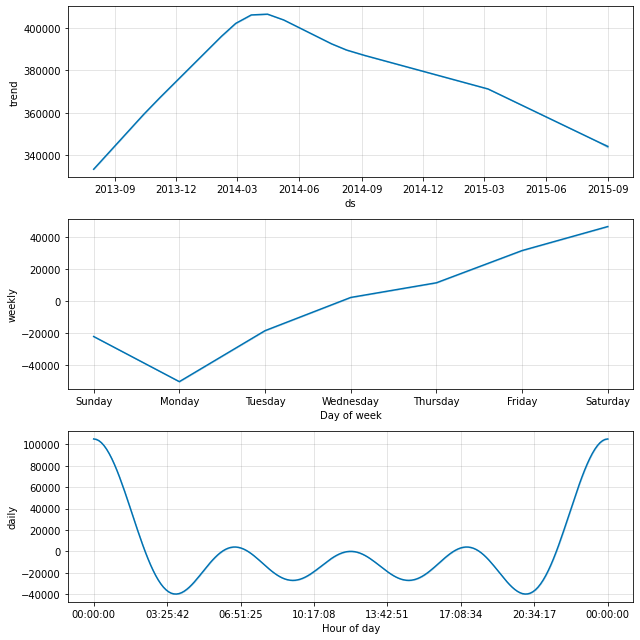

time: 318 ms (started: 2021-08-02 12:59:05 +00:00)


In [25]:
fig = m.plot_components(forecast)

# Testing out Uber Orbit

In [27]:
from orbit.models.dlt import DLTFull
from orbit.diagnostics.plot import plot_predicted_data

time: 336 µs (started: 2021-08-02 12:59:07 +00:00)


In [28]:
dlt = DLTFull(
    response_col='y', date_col='ds',
    #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=7,
)

time: 506 µs (started: 2021-08-02 12:59:08 +00:00)


In [29]:
dlt.fit(df=train_prophet)

# outcomes data frame
predicted_df = dlt.predict(df=val_prophet)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b0a449c7523386cce384e92a998e71c8 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


time: 43.9 s (started: 2021-08-02 12:59:09 +00:00)


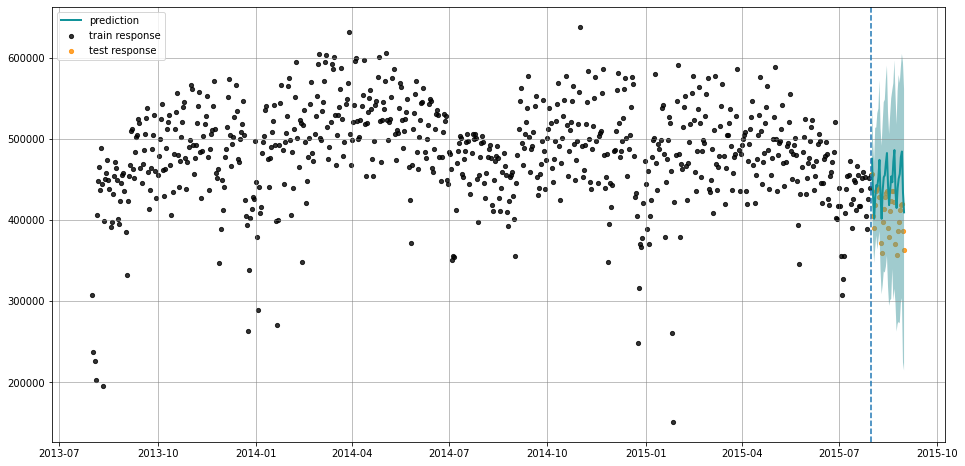

<AxesSubplot:>

time: 219 ms (started: 2021-08-02 12:59:53 +00:00)


In [30]:
plot_predicted_data(
    training_actual_df=train_prophet, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=val_prophet
)

# Testing sktime

In [31]:
from sktime.utils.plotting import plot_series
import numpy as np

time: 71.4 ms (started: 2021-08-02 13:01:15 +00:00)


In [35]:
print("min: {0}, max {1}".format(min(train.pickup_date), max(train.pickup_date)))
print("min: {0}, max {1}".format(min(val.pickup_date), max(val.pickup_date)))

min: 2013-08-01, max 2015-07-31
min: 2015-08-01, max 2015-08-31
time: 847 µs (started: 2021-08-02 13:02:03 +00:00)


In [38]:
train_tr = pd.date_range(min(train.pickup_date), max(train.pickup_date))
val_tr = pd.date_range(min(val.pickup_date), max(val.pickup_date))

assert len(train) == len(train_tr)
assert len(val) == len(val_tr)

time: 1.23 ms (started: 2021-08-02 13:05:10 +00:00)


In [54]:
train_skt_df = pd.Series(train['total_rides'].values, index=train_tr)
val_skt_df = pd.Series(val['total_rides'].values, index=val_tr)

time: 691 µs (started: 2021-08-02 13:08:01 +00:00)


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

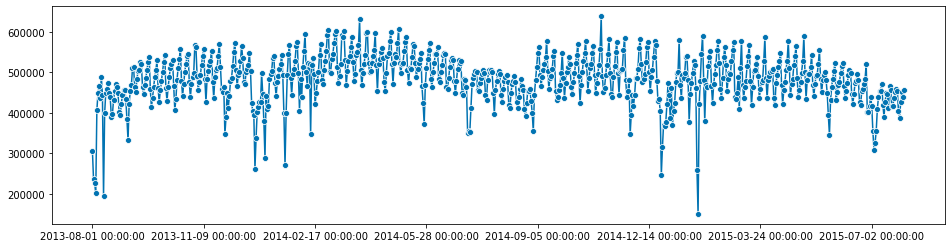

time: 229 ms (started: 2021-08-02 13:08:06 +00:00)


In [55]:
plot_series(train_skt_df)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

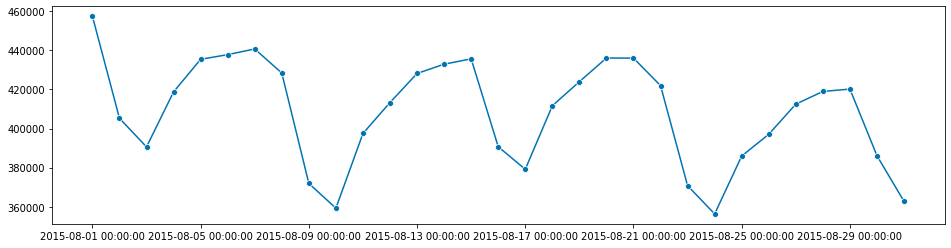

time: 107 ms (started: 2021-08-02 13:08:10 +00:00)


In [57]:
plot_series(val_skt_df)

In [68]:
# test pandas
#pd.PeriodIndex(pd.date_range("2020-01-01", periods=30, freq="D"))
from sktime.forecasting.base import ForecastingHorizon

#fh = ForecastingHorizon(test_sktime.index, is_relative=False)
fh_period = ForecastingHorizon(
    val_skt_df.index, is_relative=False
)

time: 779 µs (started: 2021-08-02 13:08:49 +00:00)


In [69]:
from sktime.forecasting.naive import NaiveForecaster

basic_forecaster =  NaiveForecaster(strategy="last")
forecaster = NaiveForecaster(strategy="last")

time: 448 µs (started: 2021-08-02 13:08:50 +00:00)


In [70]:
forecaster.fit(train_skt_df)

NaiveForecaster()

time: 1.86 ms (started: 2021-08-02 13:08:52 +00:00)


In [71]:
# stuck here for now
preds = forecaster.predict(fh_period)

time: 3.26 ms (started: 2021-08-02 13:08:53 +00:00)


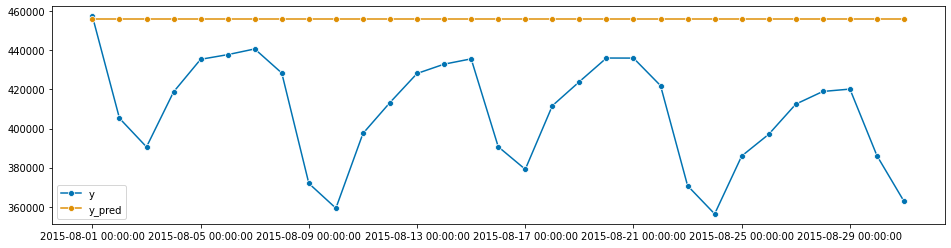

time: 140 ms (started: 2021-08-02 13:08:54 +00:00)


In [72]:
fig, ax = plot_series(val_skt_df, preds, labels=["y", "y_pred"])

In [73]:
from sktime.forecasting.theta import ThetaForecaster

time: 286 µs (started: 2021-08-02 13:08:56 +00:00)


In [74]:
# theta forecasting
th_forecaster = ThetaForecaster(sp=12)
th_forecaster.fit(train_skt_df)

alpha = 0.05
y_pred, y_pred_ints = th_forecaster.predict(fh_period, return_pred_int=True, alpha=alpha)

time: 16.1 ms (started: 2021-08-02 13:09:01 +00:00)


/home/jovyan/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


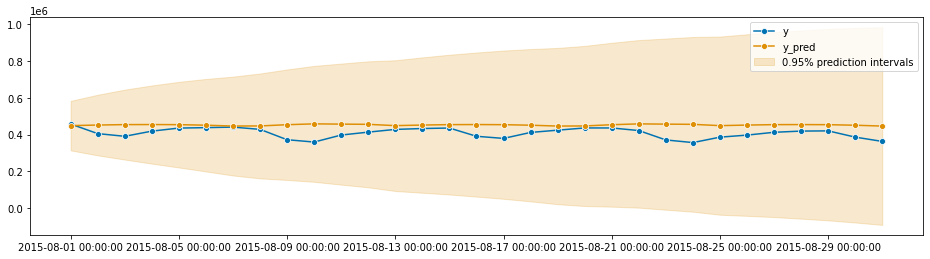

time: 146 ms (started: 2021-08-02 13:09:10 +00:00)


In [75]:
fig, ax = plot_series(val_skt_df, y_pred, labels=["y", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    y_pred_ints["lower"],
    y_pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

# GluonTS

In [76]:
from gluonts.dataset.common import ListDataset
import matplotlib.pyplot as plt

time: 85.1 ms (started: 2021-08-02 13:09:32 +00:00)


In [77]:
print(train_skt_df.values.shape)
print(val_skt_df.values.shape)

(730,)
(31,)
time: 409 µs (started: 2021-08-02 13:09:36 +00:00)


In [120]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': train_skt_df.values.astype(int), 'start':train_skt_df.index[0].to_pydatetime() }],
    freq="1D"
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': val_skt_df.values.astype(int), 'start': val_skt_df.index[0].to_pydatetime() }],
    freq="1D"
)

time: 706 µs (started: 2021-08-02 13:47:48 +00:00)


In [121]:
#type(train_skt_df.index[0])
type(train_skt_df.index[0].to_pydatetime())
train_skt_df.index[0].to_pydatetime()
#train_skt_df.values

datetime.datetime(2013, 8, 1, 0, 0)

time: 1.65 ms (started: 2021-08-02 13:47:53 +00:00)


In [122]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.mx import Trainer

time: 324 µs (started: 2021-08-02 13:47:54 +00:00)


In [123]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=len(val_skt_df),
    context_length=100,
    freq="D",
    trainer=Trainer(
        ctx="cpu",
        epochs=20,
        learning_rate=1e-3,
        num_batches_per_epoch=100
    )
)

time: 844 µs (started: 2021-08-02 13:47:56 +00:00)


In [124]:
predictor = estimator.train(training_data=train_ds)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: unhashable type: 'pandas._libs.tslibs.offsets.Day'

time: 23.2 ms (started: 2021-08-02 13:47:57 +00:00)


In [ ]:
from gluonts.evaluation import make_evaluation_predictions

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

In [ ]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [ ]:
plot_prob_forecasts(ts_entry, forecast_entry)

# Statsmodels

In [ ]:
import statsmodels.api as sm

In [ ]:
mod = sm.tsa.SARIMAX(train['y'], order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

## Stopping Spark Session

In [ ]:
spark.stop()